# exp 9 폐렴아 기다려라!

## <<  평 가 사 항  >>
### 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.<br>
**잘 확인 하였습니다.**

### 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.<br>
**여러 기법 사용하여 다양한(수많은) 실험을 체계적(주먹구구식)으로 수행 하였습니다.**

### 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
Accuracy 기준 85%에 도달하였다.<br>
**예. 86%의 정확도를 기록 하였습니다.**

### 회고는 제일 마지막에 있습니다.

***
### 1. Set up

In [1]:

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print("🍎")

🍎


In [2]:
# 필요한 변수를 생성 한다. 

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16 # 16이 가장 좋다
EPOCHS = 26     # 25가 가장 좋다 

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("# of train data :{}".format(len(train_filenames)))
print("# of test  data :{}".format(len(test_filenames)))
print("# of val   data :{}".format(len(val_filenames)))

# print(val_filenames)

# of train data :5216
# of test  data :624
# of val   data :16


***
### 2. 데이터 가져오기

In [4]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path :\n{filenames[0]}')
print(f'Pneumonia image path :\n{filenames[2000]}')

4185
1047
Normal image path :
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path :
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [5]:
# 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 
# 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다

# filename에 저장한 파일명의 path 확인 하여 정상/팽렴을 판단 한다. (이게 좋은 방법인가???)
    
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
# 오늘의 tensorflow TIP!!!
# from_tensor_slices()를 쓰면 numpy array를 바로 Dataset으로 변환해 준다.
# 그러나 대용량의 데이터라면????? Generator 사용하자
# 읽어서 익혀라 : 대용량 훈련 데이터 처리 - Generator로 TF Dataset 만들기(https://jins-sw.tistory.com/14)

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(f"train_list_ds : {tf.data.experimental.cardinality(train_list_ds).numpy()}")
print(f"val_list_ds : {tf.data.experimental.cardinality(val_list_ds).numpy()}")


train_list_ds : 4185
val_list_ds : 1047


In [7]:
# 집합론에서, 집합의 크기(영어: cardinality) 또는 농도(濃度)는 집합의 "원소 개수"에 대한 척도이다

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


***
### 3. 데이터를 전처리 한다.
#### 필요함수를 만듬
#### get_label(file_path) : 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분<br>decode_img(img) : 이미지를 알맞은 형식으로 바꿉니다.<br>process_path(file_path) : 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.

In [8]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 정리된 이미지와 라벨(T/F)을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출 boolean값 : 폐렴이면 양성(True), 노말이면 음성(False)
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

print("🍎")

🍎


In [9]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print(f"train_ds : {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"val_ds : {tf.data.experimental.cardinality(val_ds).numpy()}")


train_ds : 4185
val_ds : 1047


In [10]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(2): # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


In [11]:
# test 데이터셋 만들고, 데이터 개수 확인 (train, validation 데이터를 준비한 것을 모두 적용하여 만듦)

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)                      # return : Dataset
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy() # return : numpy.int64
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)     # return : Dataset

print(tf.data.experimental.cardinality(test_ds).numpy())

test_ds = test_ds.batch(BATCH_SIZE)                                       # return : Dataset

print(TEST_IMAGE_COUNT)
print(tf.data.experimental.cardinality(test_ds).numpy())

# # ds = tf.data.TFRecordDataset(dataset_filenames)
# ds_size = sum(1 for _ in test_ds)
# print(ds_size)

# Iterator = test_ds.make_initializable_iterator()
# batchdata = Iterator.get_next()
# with tf.Session() as sess:
#     sess.run(Iterator.initializer)
#     print(np.shape(sess.run(batchdata)[0])[0])

624
624
39


In [12]:
# tf.data 파이프라인, shuffle(), repeat(), batch(), prefetch() 사용
# 자세한 내용은 본문과 메모에 있음.

# 사진의 좌우 반전 (data augmentation)
   
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.map(augment, num_parallel_calls=2)       # augment 함수 적용 !!!!!!
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def prepare_for_training2(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2)       # augment 함수 적용 !!!!!!
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds1 = prepare_for_training(train_ds)
val_ds1 = prepare_for_training(val_ds)

train_ds2 = prepare_for_training2(train_ds)
val_ds2 = prepare_for_training2(val_ds)

train_ds = train_ds1.concatenate(train_ds2)
val_ds = val_ds1.concatenate(val_ds2)

print("🍎")

🍎


***
### 3. 데이터 시각화

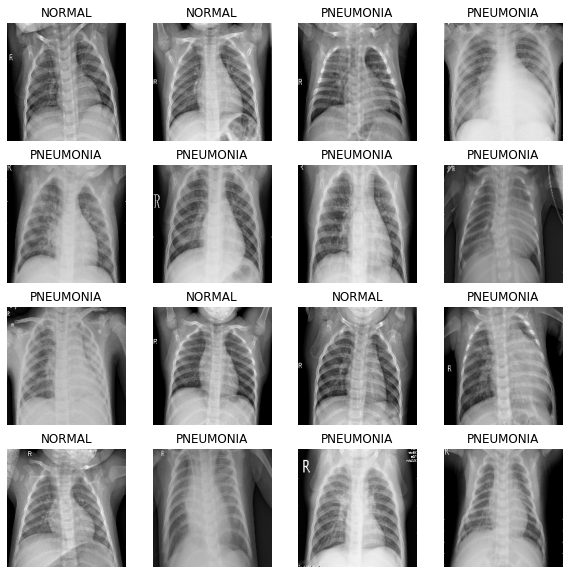

In [13]:
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 
# 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds)) # 
show_batch(image_batch.numpy(), label_batch.numpy())

***
## 4. CNN 모델링

Batch Normalization과 Dropout을 동시에 사용하는 것은 일반적이지 않지만... 그렇지 않다는 반론도 상당수 있다. <br>
여기에서는 **둘다 사용**하였다. 

In [14]:
# ********************************
# Convolution block 만들기. conv_block()의 구성
# 
# 1. Convolution을 두 번 진행
# 2. Batch Normalization 진행  
#    - Gradient vanishing, Gradient Exploding을 해결합
# 3. Max Pooling

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [15]:
# ********************************
# Dense block만들기.
# 
# 1. Dense layer (relu activation fn)
# 2. Batch Normalization 진행  
#    - Gradient vanishing, Gradient Exploding을 해결합
# 3. Dropout

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
# ********************************
# Model Build
# 

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance(불균형) 처리

**클래스 균형 클래스 균형은 소수의 클래스에 특별히 더 큰 관심이 있는 경우**에 필요하다. <br>
Data의 label이 한 쪽으로 치우치는 것 같이 imbalance 한 경우에 학습이 잘 되지 않느다. <br>
이런 경우 imbalance한 문제를 해결하는 방법으로 **Weight balancing** 이라는 테크닉이 사용됩니다.


**Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.**<br>Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

In [17]:
# Weight balancing
# weight_for_0은 'Normal' 이미지에 사용할 weight
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight
# class수가 더 적은 정상에 가중치를 더 높게 설정 한다. (이를 나타낸 수식은 ????)

# weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0     
# weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0


weight_for_0 = COUNT_PNEUMONIA / (COUNT_NORMAL + COUNT_PNEUMONIA)
weight_for_1 = COUNT_NORMAL / (COUNT_NORMAL + COUNT_PNEUMONIA)



class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


Weight for NORMAL: 0.74
Weight for PNEUMONIA: 0.26


## 5. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [ # 성과에 대해서 측정하기 위하여 'accuracy', 'precision', 'recall'을 사용 (why????)
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문
        metrics=METRICS
    )

In [19]:
# model fit 

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
# BATCH_SIZE = 16
# EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/26
261/261 [==============================] - 85s 197ms/step - loss: 0.1350 - accuracy: 0.8142 - precision: 0.9657 - recall: 0.7781 - val_loss: 1.2730 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/26
261/261 [==============================] - 50s 193ms/step - loss: 0.0884 - accuracy: 0.8970 - precision: 0.9803 - recall: 0.8792 - val_loss: 1.7945 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/26
261/261 [==============================] - 51s 195ms/step - loss: 0.0786 - accuracy: 0.9073 - precision: 0.9809 - recall: 0.8929 - val_loss: 0.2008 - val_accuracy: 0.9433 - val_precision: 0.9889 - val_recall: 0.9332
Epoch 4/26
261/261 [==============================] - 51s 196ms/step - loss: 0.0673 - accuracy: 0.9267 - precision: 0.9845 - recall: 0.9162 - val_loss: 0.1254 - val_accuracy: 0.9567 - val_precision: 0.9877 - val_recall: 0.9527
Epoch 5/26
261/261 [==============================] - 53s 202ms/step - loss: 0.0668 - accura

## 7. 결과 확인

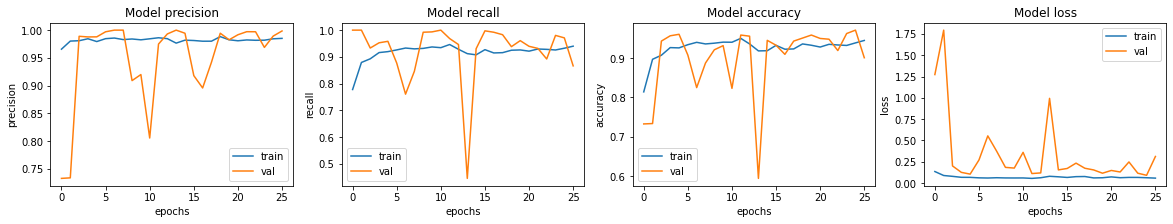

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
# 테스트 데이터로 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 111ms/step - loss: 0.5571 - accuracy: 0.8606 - precision: 0.8616 - recall: 0.9256
Loss: 0.5570619702339172,
Accuracy: 0.8605769276618958,
Precision: 0.861575186252594,
Recall: 0.9256410002708435


## 회고

1. 결과 입니다. 
- **LMS상의 오리지널 결과**<br>
39/39 [==============================] - 4s 110ms/step - loss: 1.0369 - accuracy: 0.7804 - precision: 0.7428 - recall: 0.9923<br>
Loss: 1.0368987321853638,<br>
 **Accuracy: 0.7804487347602844,**<br>
Precision: 0.7428023219108582,<br>
Recall: 0.9923076629638672<br><br>

- **Data Augumentation한 결과**<br>
39/39 [==============================] - 5s 120ms/step - loss: 0.9792 - accuracy: 0.8093 - precision: 0.7737 - recall: 0.9821<br>
Loss: 0.97919100522995,<br>
 **Accuracy: 0.8092948794364929,**<br>
Precision: 0.773737370967865,<br>
Recall: 0.9820512533187866<br><br>
기존의 전처리한 데이터와 플립한 데이터를 합쳐서 위의 실험보다 train, validation 시의 데이터 수를 2배로 하여 학습하였음.<br><br>
dataset의 크기(양)을 알 수있는 방법을 모르겠다. batchdatadaset으로 변경 하기전에는 데이터의 양를 확인 할 수있는데,<br>
batchdataset 으로 변경 된 이후에는 dataset의 양을 알 수있는 방법이 없었다. <br>
dataset에서 양을 아는 방법을 사용하면 batch나 prepatch된 것 같은 적은 양의 데이터 수만 확인이 된다. <br>
명확하게 알고싶었는데.. 아시면 좀 알려주십시요..<br><br>
 **정확도**는 학습하는 데이터가 늘어서 그런지 조금 올라서 간신히 **80%**가 되었고, 의미 있다고 생각된다.<br><br>

- **Epoch값 변경 (25번 => 30번)**<br>
39/39 [==============================] - 4s 112ms/step - loss: 1.1471 - accuracy: 0.7756 - precision: 0.7395 - recall: 0.9897<br>
Loss: 1.1470551490783691,<br>
 **Accuracy: 0.7756410241127014,**<br>
Precision: 0.7394636273384094,<br>
Recall: 0.9897435903549194<br><br>
Epoch값을 25에서 30으로 상향 하였다. original 시각화 그래프를 보면 상승 추세인 것 같아 늘렸지만... 결과는 정확도 77%로 실패였다. <br><br>

- **BN, Dropout의 조정**<br>
BN은 살리고, Dropout은 죽이고<br>
BN은 죽이고, Dropout은 살리고<br>
Convolution과 관련된 부분의 BN은 살리고, dropout은 죽이고 하여도... 모두 73% ~ 78%  사이로 몯 저조 하였다. 실패.<br>
너무 처참하여 평가 정보는 올리지 않았습니다. <br><br>


- **Data Imbalance조정**<br>
지금까지 가장 좋은 data augmentation한 설정에 data imbalance를 LMS에 되어있는 것을 아래와 같이 조정 하였다. 

>weight_for_0 = COUNT_PNEUMONIA / (COUNT_NORMAL + COUNT_PNEUMONIA)<br>
>weight_for_1 = COUNT_NORMAL / (COUNT_NORMAL + COUNT_PNEUMONIA)<br>
>>Weight for NORMAL: 0.74<br>
>>Weight for PNEUMONIA: 0.26<br><br>

39/39 [==============================] - 4s 111ms/step - loss: 0.5571 - accuracy: 0.8606 - precision: 0.8616 - recall: 0.9256<br>
Loss: 0.5570619702339172,<br>
 **Accuracy: 0.8605769276618958,**<br>
Precision: 0.861575186252594,<br>
Recall: 0.9256410002708435<br>

### 86% 나왔습니다.  정말 힘듭니다. <br><br>그래프를 보는 것도 아직 모자라고... 결과값에 대한 정확한 이해도 부족하고..<br><br>아직은 소발에 쥐잡은 것 같습니다. 